In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from os import listdir
import pandas as pd
import numpy as np

In [3]:
from dlmi.visualization import *
from dlmi.utils import get_size_of_file, load_pickle
search_type = 'leaf'

# Graph 1 -- SIFt -- 1M

In [4]:
#dyn = '../experiments/2022-11-23--19-44-31-13364399-SIFT-1000000-adan6.grid.cesnet.cz'
#bulk = '../experiments/2022-12-05--08-58-43-13575368-SIFT-bulk-MLP-1000000-adan7.grid.cesnet.cz'
dyn = '../experiments/2022-12-02--10-12-30-13425037-SIFT-1000000-adan7.grid.cesnet.cz'
bulk = '../experiments/2022-12-30--18-38-41-13825624-SIFT-bulk-MLP-1000000-adan6.grid.cesnet.cz'
naive_dyn = '../experiments/2022-12-31--19-29-57-13828510-SIFT-bulk-MLP-1000000-adan52.grid.cesnet.cz'

In [5]:
df = pd.read_csv(f'{dyn}/struct/str-36.csv')
n_leaf_nodes_d = df[df['type'] == 'LeafNode'].shape[0]
df_b = pd.read_csv(f'{bulk}/struct/str-99.csv')
n_leaf_nodes_b = df_b[df_b['type'] == 'LeafNode'].shape[0]
df = pd.read_csv(f'{naive_dyn}/struct/str-99.csv')
n_leaf_nodes_nd = df[df['type'] == 'LeafNode'].shape[0]

In [6]:
n_leaf_nodes_d, n_leaf_nodes_b, n_leaf_nodes_nd

(12061, 12000, 1200)

In [7]:
df_b.head()

,key,type,children
0,"(0,)",InnerNode,100
1,"(0, 0)",InnerNode,120
2,"(0, 0, 0)",LeafNode,98
3,"(0, 0, 1)",LeafNode,36
4,"(0, 0, 2)",LeafNode,61


In [8]:
df.head()

,key,type,children
0,"(0,)",InnerNode,100
1,"(0, 0)",InnerNode,12
2,"(0, 0, 0)",LeafNode,109
3,"(0, 0, 1)",LeafNode,154
4,"(0, 0, 2)",LeafNode,76


In [9]:
def get_search_df(exp, objs=1_000_000, type_s='leaf'):
    search_df = pd.DataFrame([])
    for f in listdir(f'{exp}/search/{type_s}/csv/'):
        if all(pd.read_csv(f'{exp}/search/{type_s}/csv/{f}')['n-objects-total'].values == objs):
            search_df = pd.concat([search_df, pd.read_csv(f'{exp}/search/{type_s}/csv/{f}')])
    return search_df

In [10]:
def get_recalls(search_df, n_leaf_nodes, search_type='leaf'):
    recalls = []
    mean_recalls = []
    stop_conds = []
    stop_conds_time = []
    seq_search_time = []
    n_queries = 0

    for n, g in search_df.groupby(['sc']):
        n_queries = g['recall'].values.shape[0]
        if search_type == search_type:
            r = (n/n_leaf_nodes)*100
            stop_conds.append(
                f'{round(r, 2) if r < 1 else int(r)}%'
            )
            stop_conds_time.append(round(g['time'].mean(), 3))
            seq_search_time.append(round(g['time-seq-search'].mean(), 3))
        recalls.append(g['recall'].values)
        mean_recalls.append(np.mean(g['recall'].values))
    return recalls, mean_recalls, stop_conds, stop_conds_time, seq_search_time

In [11]:
search_df_d = get_search_df(dyn)
recalls_d, mean_recalls_d, stop_conds, stop_conds_time_d, seq_search_time_d = get_recalls(search_df_d, n_leaf_nodes_d)
search_df_nd = get_search_df(naive_dyn)
recalls_nd, mean_recalls_nd, stop_conds_nd, stop_conds_time_nd, seq_search_time_nd = get_recalls(search_df_nd, n_leaf_nodes_nd)
search_df_b = get_search_df(bulk)
recalls_b, mean_recalls_b, stop_conds_b, stop_conds_time_b, seq_search_time_b = get_recalls(search_df_b, n_leaf_nodes_b)

In [12]:
stop_conds, stop_conds_nd, stop_conds_b

(['0.05%', '0.1%', '0.3%', '0.5%', '0.99%', '2%', '4%', '9%', '19%', '29%'],
 ['0.08%', '0.25%', '0.5%', '1%', '3%', '5%', '10%', '20%', '30%'],
 ['0.05%', '0.1%', '0.3%', '0.5%', '1%', '3%', '5%', '10%', '20%', '30%'])

In [13]:
stop_conds = ['.05', '.1', '.3', '.5', '1', '3', '5', '10', '20', '30']
mask_present_d = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mask_present_nd = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mask_present_b = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
import matplotlib
font = {'size': 18}

matplotlib.rc('font', **font)

In [15]:
def plot_line_with_boxplots_graph(
    data_values_a,
    data_values_b,
    data_values_c,
    mean_data_values_a,
    mean_data_values_b,
    mean_data_values_c,
    present_values_a,
    present_values_b,
    present_values_c,
    ticks,
    #ticks_z,
    x_label='',
    title='',
    y_label='',
    legend_loc='lower right',
    ylim=True,
    pad_to_10=False,
    legend='lower right'
):
    """ Creates time-recall and stopcond-recall plots of connected scatterpoints.

    Parameters
    -------
    save : bool
        Should the plot be saved.
    filename : str
        Filename to save as.
    dir_to_save_to : str
        Directory to save to.
    """
    fig, ax = plt.subplots(figsize=(7, 4.3))
    def set_box_color(bp, color):
        for i in ['boxes', 'medians', 'caps', 'whiskers']:
            plt.setp(bp[i], color=color)

    padding = pad_to_10 if pad_to_10 else 0
    colors = ['#D7191C', '#2C7BB6', '#0D8A51']
    
    for en, (color, data_values, positions, present_values) in enumerate(zip(
        colors,
        [data_values_a, data_values_b, data_values_c],
        [np.array(range(len(stop_conds)))*2.0 - 0.5, np.array(range(len(stop_conds)))*2.0, np.array(range(len(stop_conds)))*2.0 + 0.5],
        [present_values_a, present_values_b, present_values_c]
    )):
        data_value_idx = 0
        for pos, present_value in zip(positions, present_values):
            if present_value != 0:
                data_value = data_values[data_value_idx]
                data_value_idx += 1
                bpl = plt.boxplot(data_value, positions=[pos], sym='', widths=0.5)
                set_box_color(bpl, color)

    plt.plot(np.array([i for i in range(len(stop_conds)) if present_values_a[i] != 0])*2.0, mean_data_values_a, marker='o', color=colors[0], label='Static')
    plt.plot(np.array([i for i in range(len(stop_conds)) if present_values_b[i] != 0])*2.0, mean_data_values_b, marker='.', color=colors[1], label='Dynamic')
    plt.plot(np.array([i for i in range(len(stop_conds)) if present_values_c[i] != 0])*2.0, mean_data_values_c, marker='x', color=colors[2], label='Naive dyn.')
    
    plt.legend(prop={'size': 8}, loc=legend_loc)
    plt.xticks(range(0, len(ticks)* 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)

    #plt.xticks(range(0, len(ticks), 1), ticks)
    if ylim:
        plt.ylim(-0.01, 1.05)
    plt.grid(axis='y')
    plt.legend(loc=legend)
    #plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel(x_label)
    #ax2 = ax.secondary_xaxis('top')
    #ax2.set_xticks(range(0, len(ticks_z)* 2, 2))
    #ax2.set_xticklabels(ticks_z)
    #ax2.set_xlabel('time -- navigation (s)\n time -- sequential search of candidate answer (s)')
    plt.ylabel(y_label)
    return fig

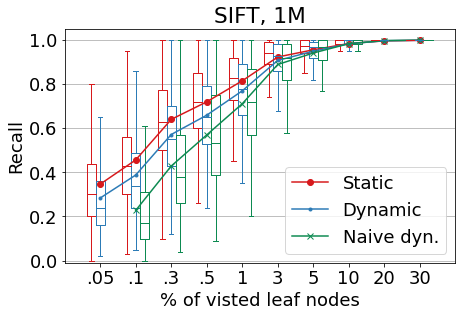

In [16]:
fig = plot_line_with_boxplots_graph(
    recalls_b,
    recalls_d,
    recalls_nd,
    mean_recalls_b,
    mean_recalls_d,
    mean_recalls_nd,
    mask_present_b,
    mask_present_d,
    mask_present_nd,
    stop_conds,
    #joint_stop_conds,
    '% of visted leaf nodes',
    'SIFT, 1M',#'Search performance -- GloVe, 1M objects, 1000 queries',
    y_label='Recall',
    pad_to_10=3
)

In [17]:
fig.savefig('../figures/search-sift-leaf-1M.pdf', bbox_inches='tight', format='pdf')

In [18]:
search_df_d = get_search_df(dyn, type_s='leaf-absolute')
recalls_d, mean_recalls_d, _, stop_conds_time_d, seq_search_time_d = get_recalls(search_df_d, n_leaf_nodes_d)
search_df_nd = get_search_df(naive_dyn, type_s='leaf-absolute')
recalls_nd, mean_recalls_nd, _, stop_conds_time_nd, seq_search_time_nd = get_recalls(search_df_nd, n_leaf_nodes_nd)
search_df_b = get_search_df(bulk, type_s='leaf-absolute')
recalls_b, mean_recalls_b, _, stop_conds_time_b, seq_search_time_b = get_recalls(search_df_b, n_leaf_nodes_b)

In [19]:
search_df_d['sc-type'].value_counts()

leaf    10000
Name: sc-type, dtype: int64

In [20]:
search_df_b['time'].mean(), search_df_nd['time'].mean(), search_df_b[search_df_b['sc'] == 1]['time'].mean(), search_df_nd[search_df_nd['sc'] == 1]['time'].mean()

(0.00340383095741272,
 0.003108353877067566,
 0.001720022439956665,
 0.0016380548477172852)

In [21]:
def get_n_parent_nodes_accessed(pq):
    parents = []
    for leaf_node in eval(pq):
        parents.append(leaf_node[:-1])
    return len(set(parents))

In [22]:
search_df_b['n-parents-accessed'] = search_df_b['query-predicted-pos'].apply(lambda x: get_n_parent_nodes_accessed(x))
search_df_nd['n-parents-accessed'] = search_df_nd['query-predicted-pos'].apply(lambda x: get_n_parent_nodes_accessed(x))
search_df_d['n-parents-accessed'] = search_df_d['query-predicted-pos'].apply(lambda x: get_n_parent_nodes_accessed(x))

In [23]:
search_df_b['n-parents-accessed'].mean(), search_df_nd['n-parents-accessed'].mean(), search_df_d['n-parents-accessed'].mean()

(3.1329, 3.4224, 4.2325)

In [24]:
stop_conds = sorted(search_df_b['sc'].unique())

In [25]:
present = [1 for i in range(len(stop_conds))]

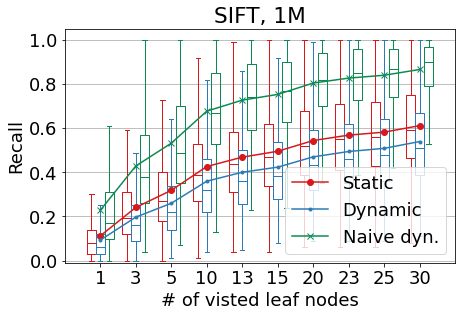

In [26]:
fig = plot_line_with_boxplots_graph(
    recalls_b,
    recalls_d,
    recalls_nd,
    mean_recalls_b,
    mean_recalls_d,
    mean_recalls_nd,
    present,
    present,
    present,
    stop_conds,
    #joint_stop_conds,
    '# of visted leaf nodes',
    'SIFT, 1M', #'Search performance -- GloVe, 1M objects, 1000 queries',
    y_label='Recall'
)

In [27]:
fig.savefig('../figures/search-sift-leaf-absolute-1M.pdf', bbox_inches='tight', format='pdf')

In [28]:
stop_conds_time_b, seq_search_time_b, stop_conds_time_nd, seq_search_time_nd

([0.002, 0.002, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.005],
 [0.002, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.012],
 [0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004],
 [0.005, 0.011, 0.018, 0.033, 0.043, 0.049, 0.066, 0.075, 0.082, 0.097])

In [29]:
def get_time(search_df, n_leaf_nodes):
    time_mean = []
    time = []
    seq_search_time_mean = []
    seq_search_time = []
    stop_conds = []
    n_queries = 0

    for n, g in search_df.groupby(['sc']):
        n_queries = g['recall'].values.shape[0]
        if search_type == 'leaf':
            r = (n/n_leaf_nodes)*100
            stop_conds.append(
                f'{round(r, 2) if r < 1 else int(r)}%'
            )
        time_mean.append(g['time'].mean())
        time.append(g['time'].values)
        seq_search_time_mean.append(g['time-seq-search'].mean())
        seq_search_time.append(g['time-seq-search'].values)
    return time, time_mean, seq_search_time, seq_search_time_mean, stop_conds

In [30]:
search_df_d = get_search_df(dyn, type_s='leaf-absolute')
recalls_d, mean_recalls_d, _, stop_conds_time_d, seq_search_time_d = get_recalls(search_df_d, n_leaf_nodes_d)
search_df_nd = get_search_df(naive_dyn, type_s='leaf-absolute')
recalls_nd, mean_recalls_nd, _, stop_conds_time_nd, seq_search_time_nd = get_recalls(search_df_nd, n_leaf_nodes_nd)
search_df_b = get_search_df(bulk, type_s='leaf-absolute')
recalls_b, mean_recalls_b, _, stop_conds_time_b, seq_search_time_b = get_recalls(search_df_b, n_leaf_nodes_b)

In [31]:
time_d, time_mean_d, seq_time_d, seq_time_mean_d, _ = get_time(search_df_d, n_leaf_nodes_d)
time_b, time_mean_b, seq_time_b, seq_time_mean_b, _ = get_time(search_df_b, n_leaf_nodes_b)
time_nd, time_mean_nd, seq_time_nd, seq_time_mean_nd, _ = get_time(search_df_nd, n_leaf_nodes_nd)

In [32]:
len(time_mean_nd)

10

In [33]:
stop_conds

[1, 3, 5, 10, 13, 15, 20, 23, 25, 30]

In [34]:
n_leaf_nodes_b, n_leaf_nodes_nd

(12000, 1200)

In [35]:
search_df_b['time'].head()

0    0.002257
1    0.001718
2    0.001658
3    0.001648
4    0.001645
Name: time, dtype: float64

In [36]:
search_df_nd['time'].head()

0    0.003383
1    0.003989
2    0.003406
3    0.002856
4    0.003402
Name: time, dtype: float64

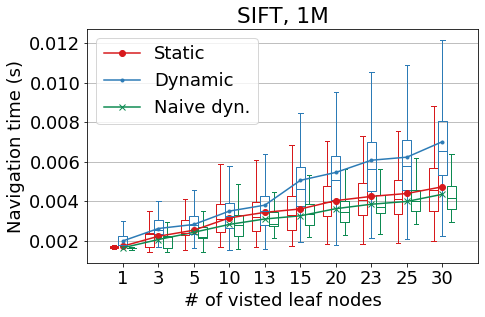

In [37]:
fig = plot_line_with_boxplots_graph(
    time_b,
    time_d,
    time_nd,
    time_mean_b,
    time_mean_d,
    time_mean_nd,
    present,
    present,
    present,
    stop_conds,
    #joint_stop_conds,
    '# of visted leaf nodes',
    'SIFT, 1M',
    ylim=False,
    y_label='Navigation time (s)',
    legend='upper left'
)

In [38]:
fig.savefig('../figures/search-sift-leaf-absolute-navigation-costs-1M.pdf', bbox_inches='tight', format='pdf')

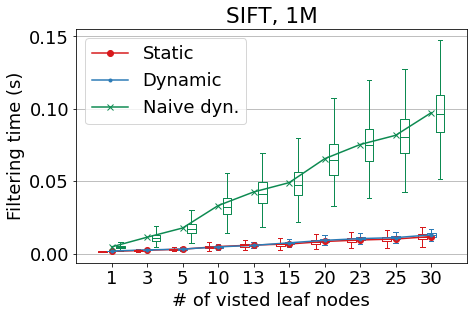

In [39]:
fig = plot_line_with_boxplots_graph(
    seq_time_b,
    seq_time_d,
    seq_time_nd,
    seq_time_mean_b,
    seq_time_mean_d,
    seq_time_mean_nd,
    present,
    present,
    present,
    stop_conds,
    #joint_stop_conds,
    '# of visted leaf nodes',
    'SIFT, 1M',
    ylim=False,
    y_label='Filtering time (s)',
    legend='upper left'
)

In [40]:
fig.savefig('../figures/search-sift-leaf-absolute-filtering-costs-1M.pdf', bbox_inches='tight', format='pdf')

In [42]:
seq_time_mean_b[-1], seq_time_mean_nd[-1]

(0.011831639289855957, 0.09733617091178894)